# pyfit demo

## Autograd engine

In [1]:
from pyfit.engine import Scalar

### Reverse-mode autodiff

In [2]:
x = Scalar(1.0)
z = 2 * x + 2 + x
q = z + z * x
h = z * z
y = h + q + q * x
print(y.data) # 45.0
y.backward()
print(x.grad) # 62.0 (the numerical value of dy/dx)

45.0
62.0


### Computation graph

In [3]:
# pip install graphviz
from graphviz import Digraph

def trace(root):
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root):
    nodes, edges = trace(root)
    dot = Digraph(format='png')
    
    for n in nodes:
        dot.node(name=str(id(n)), label = "{ data %.4f | grad %.4f }" % (n.data, n.grad), shape='record')
        if n._op:
            dot.node(name=str(id(n)) + n._op, label=n._op)
            dot.edge(str(id(n)) + n._op, str(id(n)))
    
    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
    
    return dot

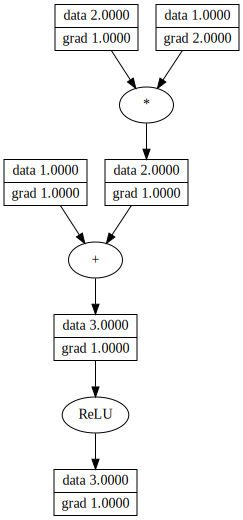

In [4]:
x = Scalar(1.0)
y = (x * 2 + 1).relu()
y.backward()
draw_dot(y)

## Single neuron

In [5]:
import random
from pyfit.nn import Neuron

random.seed(1337)
n = Neuron(2)
print(n)
print(n.parameters())

ReLUNeuron(2)
[Scalar(data=0.23550571390294128, grad=0), Scalar(data=0.06653114721000164, grad=0), Scalar(data=0, grad=0)]


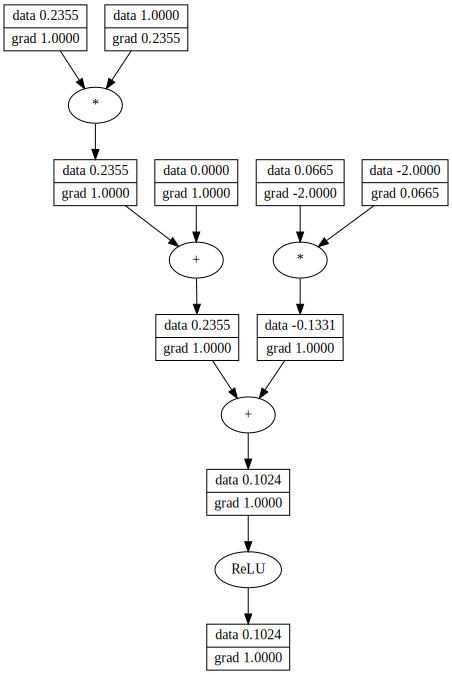

In [6]:
n.zero_grad()
x = [Scalar(1.0), Scalar(-2.0)]
y = n(x)
y.backward()
draw_dot(y)

## Multi-Layer Perceptron

### Learning XOR, using an explicit training loop

In [7]:
from pyfit.engine import Scalar

x_train = [list(map(Scalar, x)) for x in [[0, 0], [0, 1], [1, 0], [1, 1]]]
print(x_train)
y_train = [Scalar(0), Scalar(1), Scalar(1), Scalar(0)]

[[Scalar(data=0, grad=0), Scalar(data=0, grad=0)], [Scalar(data=0, grad=0), Scalar(data=1, grad=0)], [Scalar(data=1, grad=0), Scalar(data=0, grad=0)], [Scalar(data=1, grad=0), Scalar(data=1, grad=0)]]


In [8]:
from pyfit.nn import MLP
from pyfit.optim import SGD
from pyfit.metrics import mean_squared_error

model = MLP(2, [4, 1]) # 1 hidden layer
print(model)
print(f"Number of parameters: {len(model.parameters())}")

optimizer = SGD(model.parameters(), learning_rate=0.01)
num_epochs = 5000

for epoch in range(num_epochs):
    # Reset the gradients of model parameters
    optimizer.zero_grad()
    
    # Forward pass
    outputs = list(map(model, x_train))
    
    # Loss computation
    y_pred = [item for sublist in outputs for item in sublist]
    loss = mean_squared_error(y_train, y_pred)
    
    # Backprop and gradient descent
    loss.backward()
    optimizer.step()
    
    if epoch % 100 == 0:
        print(f"Epoch [{epoch}/{num_epochs}], loss: {loss.data}")

MLP of [Layer of [ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2)], Layer of [LinearNeuron(4)]]
Number of parameters: 17
Epoch [0/5000], loss: 0.34908237938599307
Epoch [100/5000], loss: 0.09107023841744905
Epoch [200/5000], loss: 0.04231874781705918
Epoch [300/5000], loss: 0.02123167702235016
Epoch [400/5000], loss: 0.010360238859374354
Epoch [500/5000], loss: 0.004995352351262309
Epoch [600/5000], loss: 0.0023846470314763486
Epoch [700/5000], loss: 0.0011992536692962017
Epoch [800/5000], loss: 0.0006253475186954571
Epoch [900/5000], loss: 0.00033259526494986466
Epoch [1000/5000], loss: 0.00017643232719684874
Epoch [1100/5000], loss: 9.335277252575738e-05
Epoch [1200/5000], loss: 4.919129874009399e-05
Epoch [1300/5000], loss: 2.602123543848514e-05
Epoch [1400/5000], loss: 1.3619045651237982e-05
Epoch [1500/5000], loss: 7.136260443869316e-06
Epoch [1600/5000], loss: 3.739540236231872e-06
Epoch [1700/5000], loss: 1.954797134034428e-06
Epoch [1800/5000], loss: 1.02664963466241

In [9]:
# Compare predictions and ground truth
for x, y in zip(x_train, y_train):
    y_pred = model(x)
    print(f"Predicted: {y_pred[0].data:.5f}, actual: {y.data}")

Predicted: 0.00000, actual: 0
Predicted: 1.00000, actual: 1
Predicted: 1.00000, actual: 1
Predicted: 0.00000, actual: 0


### Classifying 2D data, using the training API

In [10]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns
from sklearn.datasets import make_moons

In [11]:
# Setup plots
%matplotlib inline
plt.rcParams['figure.figsize'] = 10, 8
%config InlineBackend.figure_format = 'retina'
sns.set()

x_train: (200, 2). y_train: (200,)


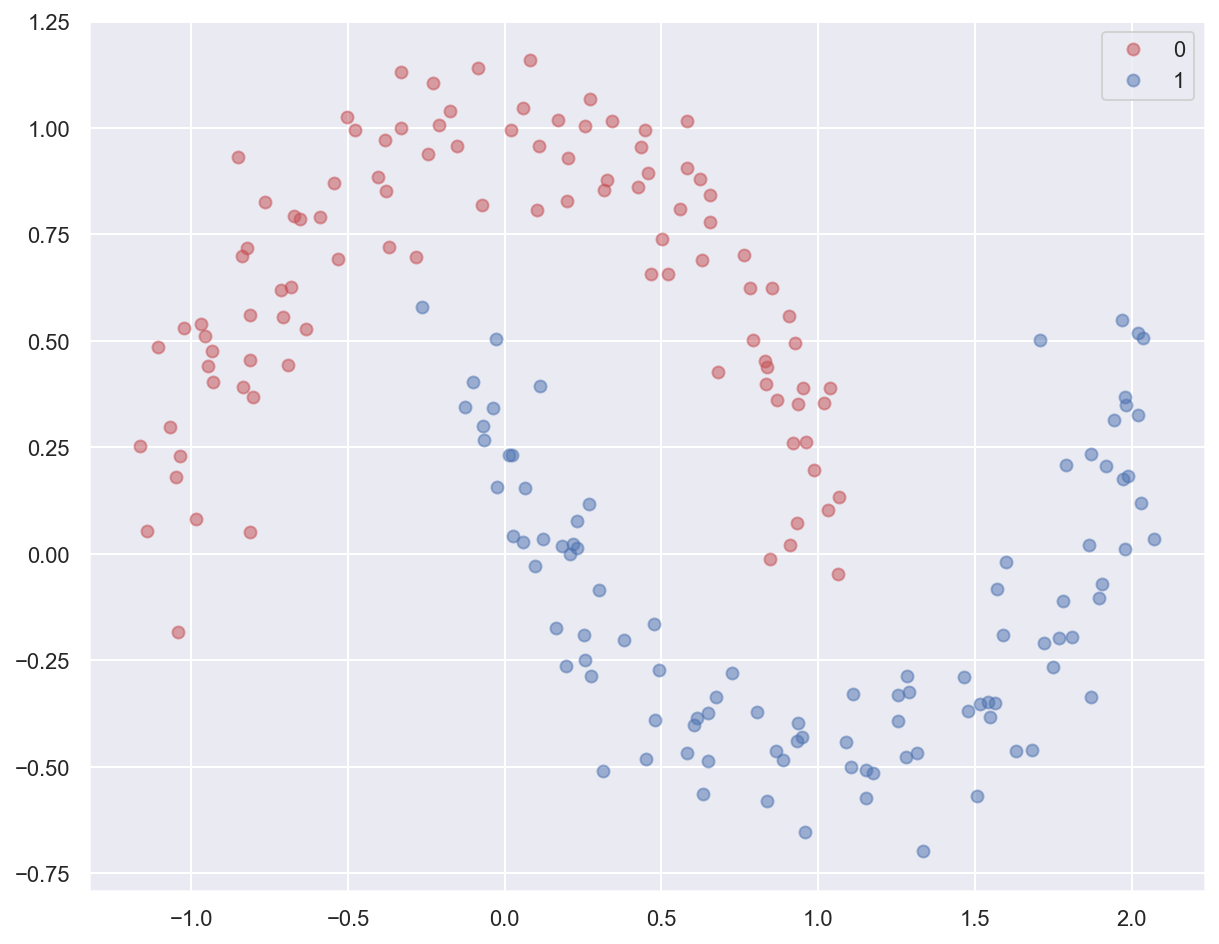

In [12]:
def plot_planar_data(X, y):
    """Plot some planar data"""

    plt.figure()
    plt.plot(X[y == 0, 0], X[y == 0, 1], 'or', alpha=0.5, label=0)
    plt.plot(X[y == 1, 0], X[y == 1, 1], 'ob', alpha=0.5, label=1)
    plt.legend()

# Generate moon-shaped, non-linearly separable data
x_train, y_train = make_moons(n_samples=200, noise=0.10, random_state=0)

print(f'x_train: {x_train.shape}. y_train: {y_train.shape}')
plot_planar_data(x_train, y_train)

In [18]:
from pyfit.data import BatchIterator
from pyfit.train import Trainer

model = MLP(2, [16, 16, 1]) # 2 hidden layers
print(model)
print(f"Number of parameters: {len(model.parameters())}")

optimizer = SGD(model.parameters(), learning_rate=0.01)
data_iterator = BatchIterator(x_train, y_train)

trainer = Trainer(model, optimizer, loss=mean_squared_error)
loss, acc = trainer.fit(data_iterator, num_epochs=50, verbose=True)

print(f"Training loss: {loss}")
print(f"Training accuracy: {acc * 100:.2f}%")

MLP of [Layer of [ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2)], Layer of [ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16)], Layer of [LinearNeuron(16)]]
Number of parameters: 337
Epoch [1/50]. Loss: 6.538404
Epoch [2/50]. Loss: 1.749324
Epoch [3/50]. Loss: 0.959983
Epoch [4/50]. Loss: 0.741578
Epoch [5/50]. Loss: 0.599237
Epoch [6/50]. Loss: 0.554916
Epoch [7/50]. Loss: 0.512475
Epoch [8/50]. Loss: 0.529890
Epoch [9/50]. Loss: 0.615732
Epoch [10/50]. Loss: 0.467007
Epoch [11/50]. Loss: 0.440244
Epoch [12/50]. Loss: 0.470594
Epoch [13/50]. Loss: 0.413798
Epoch [14/50]. Loss: 0.404845
Epoch [1

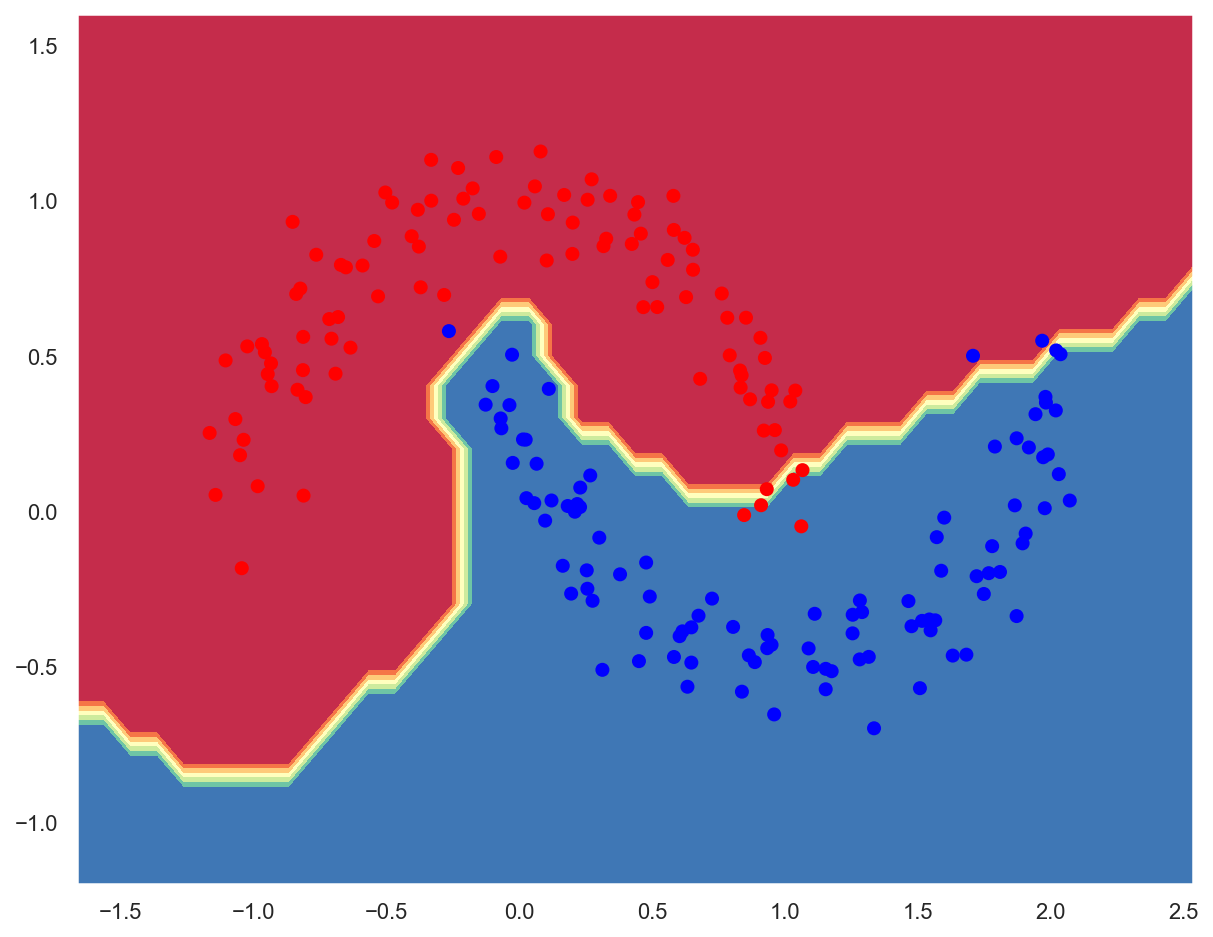

In [19]:
def plot_decision_boundary(model, X, y):
    """Plot a decision boundary"""

    # Set min and max values and give it some padding
    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    
    h = 0.1
    # Generate a grid of points with distance h between them
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    
    # Predict the function value for the whole grid
    Xmesh = np.c_[xx.ravel(), yy.ravel()]
    inputs = [list(map(Scalar, xrow)) for xrow in Xmesh]
    outputs = list(map(model, inputs))
    y_pred = [item for sublist in outputs for item in sublist]
    Z = np.array([s.data > 0.5 for s in y_pred])
    Z = Z.reshape(xx.shape)
    
    # Plot the contour and training examples
    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral)
    cm_bright = ListedColormap(['#FF0000', '#0000FF'])
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=cm_bright)

plot_decision_boundary(model, x_train, y_train)

In [20]:
# Compare predictions and ground truth
for x, y in zip(x_train[:30], y_train[:30]):
    y_pred = model(x)
    print(f"Predicted: {y_pred[0].data:.5f}, actual: {y}")

Predicted: 0.00722, actual: 0
Predicted: 0.87926, actual: 1
Predicted: 0.85733, actual: 1
Predicted: 0.08327, actual: 0
Predicted: 0.89502, actual: 1
Predicted: 0.89061, actual: 1
Predicted: 0.25269, actual: 0
Predicted: 0.97610, actual: 1
Predicted: 0.06466, actual: 0
Predicted: 1.00390, actual: 1
Predicted: 0.12246, actual: 0
Predicted: 0.91092, actual: 1
Predicted: 0.90410, actual: 1
Predicted: 0.87757, actual: 1
Predicted: 0.04086, actual: 0
Predicted: 0.37052, actual: 0
Predicted: -0.18658, actual: 0
Predicted: 0.92918, actual: 1
Predicted: -0.01464, actual: 0
Predicted: 0.08598, actual: 0
Predicted: 0.88989, actual: 1
Predicted: 0.96440, actual: 1
Predicted: -0.00950, actual: 0
Predicted: 0.85675, actual: 1
Predicted: -0.00765, actual: 0
Predicted: 0.85135, actual: 1
Predicted: 0.90253, actual: 1
Predicted: 0.86185, actual: 1
Predicted: 0.85939, actual: 1
Predicted: 0.23773, actual: 0
